In [2]:
# ! pip install mdptoolbox-hiive
# ! pip install gym
# ! pip install pymdptoolbox

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import gym
from gym import wrappers
import time
import sys
import matplotlib.pyplot as plt

In [5]:
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

def trainQLearning(P, R, test_count, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    from hiive.mdptoolbox.mdp import QLearning
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = evaluate_policy(P, R, q.policy, test_count)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

def run_Forest(states, test_count):
    import mdptoolbox, mdptoolbox.example

    print('POLICY ITERATION WITH FOREST MANAGEMENT ' + str(states) + ' STATES')
    P, R = mdptoolbox.example.forest(S=states)
    value_f = [0]*10
    policy = [0]*10
    iters = [0]*10
    time_array = [0]*10
    gamma_arr = [0] * 10
    for i in range(0,10):
        pi = mdptoolbox.mdp.PolicyIteration(P, R, (i+0.5)/10)
        pi.run()
        gamma_arr[i]=(i+0.5)/10
        value_f[i] = np.mean(pi.V)
        policy[i] = pi.policy
        iters[i] = pi.iter
        time_array[i] = pi.time

    # print('Forest Management ' + str(states) + ' states - Policy Iteration Policy')
    # print(policy)

    plt.plot(gamma_arr, time_array)
    plt.xlabel('Gammas')
    plt.title('Forest Management ' + str(states) + ' states - Policy Iteration - Execution Time Analysis')
    plt.ylabel('Execution Time (s)')
    plt.grid()
    plt.show()

    
    plt.plot(gamma_arr,value_f)
    plt.xlabel('Gammas')
    plt.ylabel('Average Rewards')
    plt.title('Forest Management ' + str(states) + ' states  - Policy Iteration - Reward Analysis')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,iters)
    plt.xlabel('Gammas')
    plt.ylabel('Iterations to Converge')
    plt.title('Forest Management ' + str(states) + ' states  - Policy Iteration - Convergence Analysis')
    plt.grid()
    plt.show()

    print('VALUE ITERATION WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = mdptoolbox.example.forest(S=states)
    value_f = [0]*10
    policy = [0]*10
    iters = [0]*10
    time_array = [0]*10
    gamma_arr = [0] * 10
    for i in range(0,10):
        pi = mdptoolbox.mdp.ValueIteration(P, R, (i+0.5)/10)
        pi.run()
        gamma_arr[i]=(i+0.5)/10
        value_f[i] = np.mean(pi.V)
        policy[i] = pi.policy
        iters[i] = pi.iter
        time_array[i] = pi.time

    # print('Forest Management ' + str(states) + ' states - Value Iteration Policy')
    # print(policy)
    
    plt.plot(gamma_arr, time_array)
    plt.xlabel('Gammas')
    plt.title('Forest Management ' + str(states) + ' states  - Value Iteration - Execution Time Analysis')
    plt.ylabel('Execution Time (s)')
    plt.grid()
    plt.show()
    
    plt.plot(gamma_arr,value_f)
    plt.xlabel('Gammas')
    plt.ylabel('Average Rewards')
    plt.title('Forest Management ' + str(states) + ' states  - Value Iteration - Reward Analysis')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,iters)
    plt.xlabel('Gammas')
    plt.ylabel('Iterations to Converge')
    plt.title('Forest Management ' + str(states) + ' states  - Value Iteration - Convergence Analysis')
    plt.grid()
    plt.show()
    
    # New way
    print('Q LEARNING WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = mdptoolbox.example.forest(S=states,p=0.01)
    eps = [0.05,0.15,0.25,0.5,0.75,0.95]
    iters = [10000, 100000, 1000000, 10000000]
    q_df = trainQLearning(P, R, test_count, discount=0.9, epsilon=eps, n_iter=iters)
    
    # print('Forest Management ' + str(states) + ' states - Q-learning Table')
    # print(q_df)
    
    fig = plt.figure()
    for frame in [q_df[(q_df.Epsilon == 0.05)], q_df[(q_df.Epsilon == 0.15)], q_df[(q_df.Epsilon == 0.25)], q_df[(q_df.Epsilon == 0.50)], q_df[(q_df.Epsilon == 0.75)], q_df[(q_df.Epsilon == 0.95)]]:
        plt.plot(frame['Iterations'], frame['Reward'])
    labels = ["epsilon=" + str(x) for x in eps]
    plt.title('Forest Management ' + str(states) + ' states - Q Learning - Constant Epsilon')
    plt.legend(labels,loc='lower right')
    plt.xlabel('Iterations')
    plt.grid()
    plt.ylabel('Reward')
    plt.show()
    
    q_df[(q_df.Iterations == 10000000)].plot(x='Epsilon', y='Time',legend=None,xlabel="Epsilon",ylabel="Time",title="Forest Management " + str(states) + " - Q Learning",grid=True)
    
    return

STARTING FOREST MANAGEMENT 20 STATES
POLICY ITERATION WITH FOREST MANAGEMENT 20 STATES


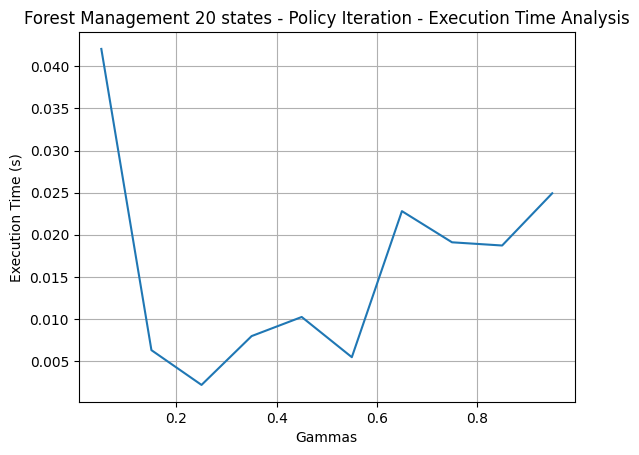

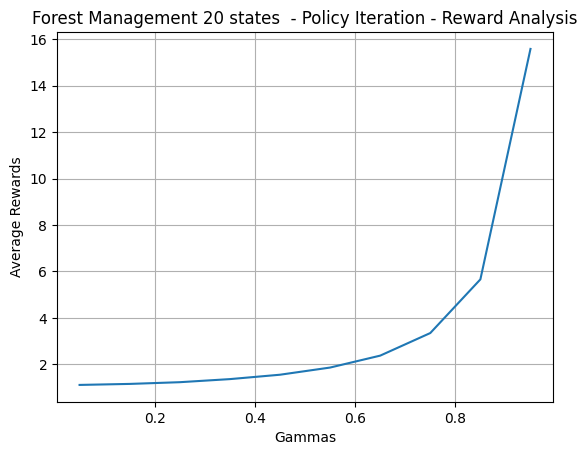

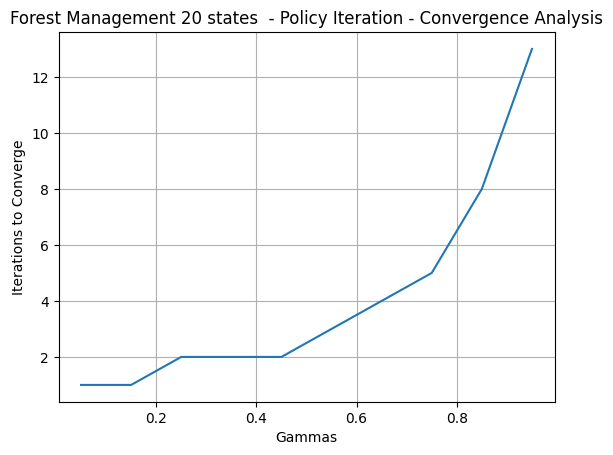

VALUE ITERATION WITH FOREST MANAGEMENT 20 STATES 


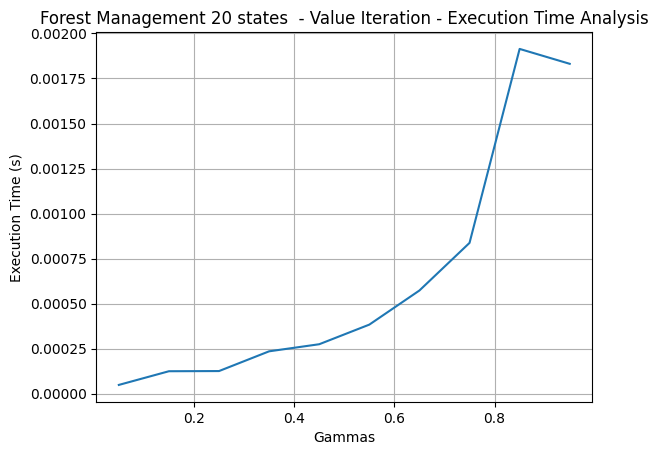

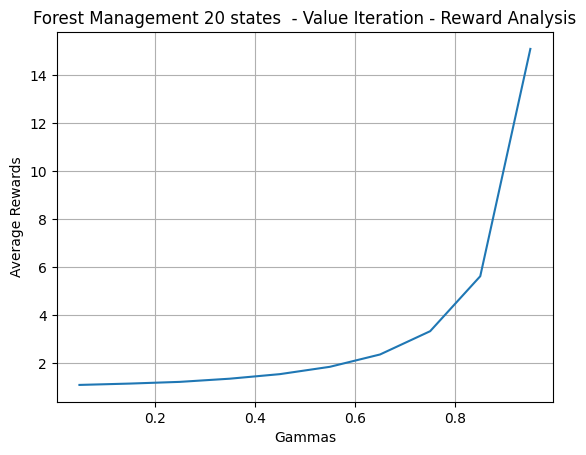

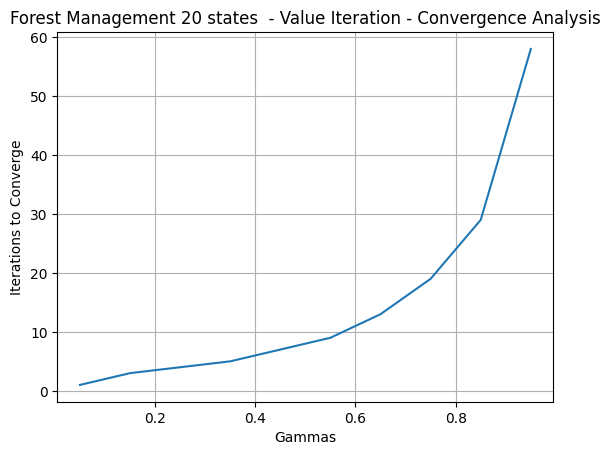

Q LEARNING WITH FOREST MANAGEMENT 20 STATES 
1: 2.2094545338715217
2: 2.3244563742417776
3: 2.227520769424898
4: 2.4314886533467295
5: 2.3132065569829563
6: 2.336298131620605
7: 2.599502925085332
8: 2.6379324033544305
9: 2.5348224410216766
10: 2.592560227477015
11: 2.598494712098703
12: 2.6732610448651912
13: 2.4851701864658153
14: 2.53064773957699
15: 2.640763867228414
16: 2.5627326944166966
17: 2.648909922548366
18: 2.740409446589543
19: 2.58417559106936
20: 0.9
21: 2.5849887936054476
22: 2.5475099861340835
23: 2.6397565156959253
24: 2.5882416373112878


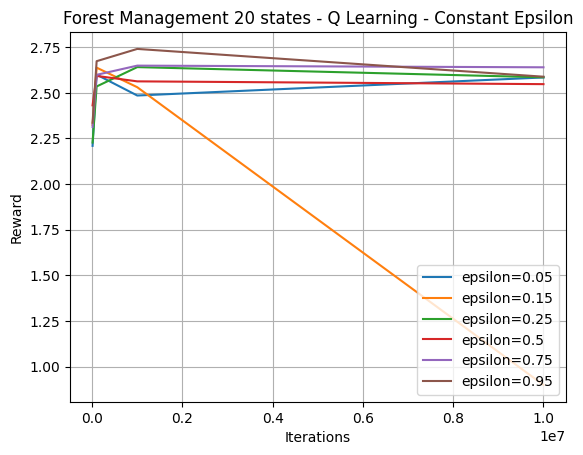

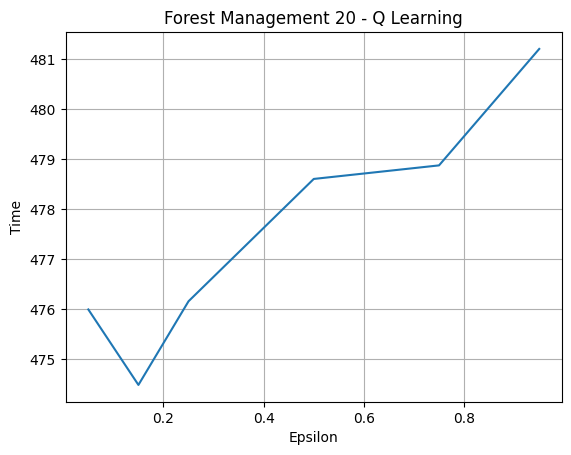

In [6]:
print('STARTING FOREST MANAGEMENT 20 STATES')
run_Forest(20, 1000) # States, test_count